In [33]:
import numpy as np
import numpy.random as rng
import scipy.stats as stats
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
# from pykalman import KalmanFilter
from statsmodels.tsa.statespace.kalman_filter import KalmanFilter
from statsmodels.tsa.statespace.kalman_filter import FilterResults
import statsmodels.api as sm
sns.set()

/home/davi/Envs/datascience/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [48]:
# simulate Y(1:100)
T = 100
phi = .95
sv = 1.0
su = 1.0
s0 = np.sqrt(su**2 / (1-phi**2))

x = np.zeros(T)
y = np.zeros(T)

x[0] = s0 * rng.standard_normal()
y[0] = x[0] + sv * rng.standard_normal()
for i in range(1,T):
  x[i] = phi * x[i-1] + su * rng.standard_normal()
  y[i] = x[i] + sv * rng.standard_normal()


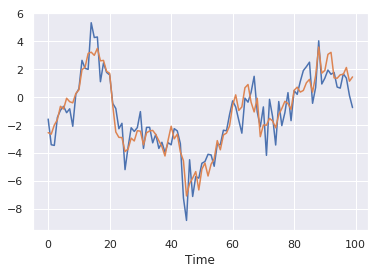

In [49]:
plt.plot(y,label="y")
plt.plot(x,label="x")
plt.xlabel("Time")
plt.savefig("./images/LinearGaussian.png")

In [87]:
# BOOTSTRAP SIS
N = 1000
XB = np.zeros(N*T).reshape(T,N)
WB = np.zeros(N*T).reshape(T,N)

# amostro aproximacao de p(x1|y1)
XB[0] = s0 * rng.standard_normal(N) 
WB[0] = -(y[0]-XB[0])**2/(2*sv**2)
# amostro condicionalmente aproximacao de p(x1:t|y1:t)
for t in range(1,T):
  XB[t] =  phi * XB[t-1] + su * rng.standard_normal(N)
  WB[t] = WB[t-1] - (y[t]-XB[t])**2/(2*sv**2)
    
def calc_weights(W,t):
  w = W[t]
  maxw = np.max(w)
  sw = np.exp(w-maxw).sum()
  return np.exp(w-maxw-np.log(sw))

WBnorm = calc_weights(WB,-1)

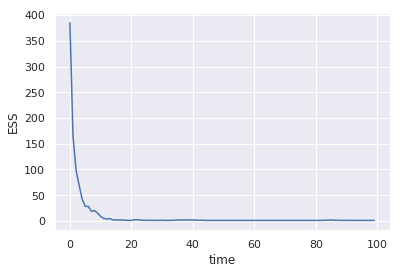

In [88]:
ESS = []
for i in range(0,100):
    ESS.append(1/sum(calc_weights(WB,i)**2))
plt.plot(ESS)
plt.xlabel("time")
plt.ylabel("ESS")
plt.savefig("./images/ESS_SIS.png")

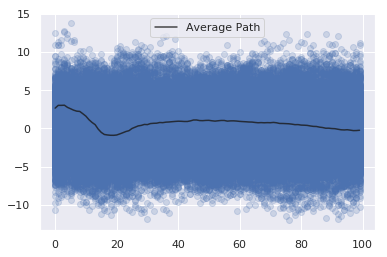

In [90]:
plt.plot(XB,'ob',alpha=0.2);
XM = []
for i in range(0,100):
    XM.append(sum(XB[i,:]*WB[i,:])/sum(WB[i,:]))
plt.plot(XM,'k',alpha=0.8,label="Average Path");
plt.legend()
plt.savefig("./images/SIS_Paths.png")

In [91]:
# http://users.isy.liu.se/rt/schon/Publications/HolSG2006.pdf
def norm_weights(w):
  maxw = np.max(w)
  sw = np.exp(w-maxw).sum()
  return np.exp(w-maxw-np.log(sw))

# implement resampling algorithm
def resample(W, A):
  N = W.shape[0]
  p = norm_weights(W)
  O = rng.multinomial(N,p)
  acc = 0
  for i in range(N):
    for j in range(O[i]):
      A[acc] = i
      acc = acc + 1
  return A


In [92]:
# BOOTSTRAP SIR
N = 1000
XB = np.zeros(N*T).reshape(T,N)
WB = np.zeros(N*T).reshape(T,N)
AB = np.zeros(N*(T-1),dtype=int).reshape(T-1,N)

# amostro aproximacao de p(x1|y1)
XB[0] = s0 * rng.standard_normal(N) 
WB[0] = -(y[0]-XB[0])**2/(2*sv**2)
# amostro condicionalmente aproximacao de p(x1:t|y1:t)
for t in range(1,T):
  resample(WB[t-1],AB[t-1])  
  XB[t] =  phi * XB[t-1,AB[t-1]] + su * rng.standard_normal(N)
  WB[t] =  - (y[t]-XB[t])**2/(2*sv**2)

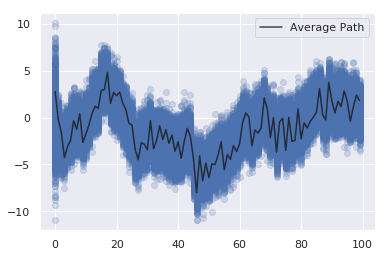

In [93]:
# plt.plot(norm_weights(WB[6]))
XM = []
for i in range(0,100):
    XM.append(sum(XB[i,:]*WB[i,:])/sum(WB[i,:]))
plt.plot(XB,'ob',alpha=0.2);
plt.plot(XM,'k',alpha=0.8,label="Average Path");
plt.legend()
plt.savefig("./images/SIR_Paths.png")

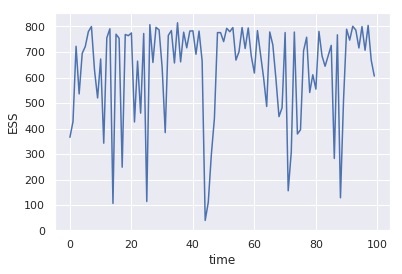

In [94]:
ESS = []
for i in range(0,100):
    ESS.append(1/sum(calc_weights(WB,i)**2))
plt.plot(ESS)
plt.xlabel("time")
plt.ylabel("ESS")
plt.savefig("./images/ESS_SIR.png")